Renan's notebook

In [1]:
from deepface import DeepFace
import cv2
import mediapipe as mp
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import kagglehub
import time

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, Grayscale
from PIL import Image
from collections import Counter
from datasets import load_dataset, concatenate_datasets

## Training model for facial emotion

In [2]:
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /Users/renan/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [8]:
emotion_train = load_dataset("/Users/renan/.cache/kagglehub/datasets/msambare/fer2013/versions/1", split="train")
emotion_test = load_dataset("/Users/renan/.cache/kagglehub/datasets/msambare/fer2013/versions/1", split="test")
dataset = load_dataset("/Users/renan/.cache/kagglehub/datasets/msambare/fer2013/versions/1")
print("Number of training samples:", len(emotion_train))
print("Number of test samples:", len(emotion_test))
# Display the first sample from the training set
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

full_dataset = concatenate_datasets([dataset['train'], dataset['test']])

emotion_train

Number of training samples: 28709
Number of test samples: 7178


Dataset({
    features: ['image', 'label'],
    num_rows: 28709
})

## First ResNet18 model for emotion classification

In [2]:
# Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Custom Dataset
class FERDataset(Dataset):
    def __init__(self, data, transform=None):
        self.images = data['image']
        self.labels = data['label']
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]  # raw image
        # Convert to PIL Image if necessary
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype(np.uint8), mode='L')
        elif isinstance(img, list):
            img = np.array(img, dtype=np.uint8)
            img = Image.fromarray(img, mode='L')
        elif isinstance(img, Image.Image):
            pass  # already PIL, do nothing
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

# Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

Using device: mps


In [5]:
# Datasets + Dataloaders
train_dataset = FERDataset(emotion_train, transform=transform)
test_dataset = FERDataset(emotion_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# Model
model_emot = models.resnet18(pretrained=True)
num_ftrs = model_emot.fc.in_features
model_emot.fc = nn.Linear(num_ftrs, 7)  # 7 emotion classes
model_emot = model_emot.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emot.parameters(), lr=1e-4)

# Training Loop
num_epochs = 15
best_acc = 0.0

for epoch in range(num_epochs):
    model_emot.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_emot(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Validation
    model_emot.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_emot(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Loss: {epoch_loss:.4f} "
          f"Train Acc: {epoch_acc:.4f} "
          f"Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model_emot.state_dict(), 'best_emotion_model.pth')

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")


Epoch [1/15] Loss: 1.1269 Train Acc: 0.5763 Val Acc: 0.6248
Epoch [2/15] Loss: 0.7767 Train Acc: 0.7154 Val Acc: 0.6516
Epoch [3/15] Loss: 0.4842 Train Acc: 0.8308 Val Acc: 0.6585
Epoch [4/15] Loss: 0.2146 Train Acc: 0.9334 Val Acc: 0.6559
Epoch [5/15] Loss: 0.1016 Train Acc: 0.9739 Val Acc: 0.6672
Epoch [6/15] Loss: 0.0608 Train Acc: 0.9861 Val Acc: 0.6496
Epoch [7/15] Loss: 0.0718 Train Acc: 0.9807 Val Acc: 0.6424
Epoch [8/15] Loss: 0.0972 Train Acc: 0.9694 Val Acc: 0.6573
Epoch [9/15] Loss: 0.0710 Train Acc: 0.9782 Val Acc: 0.6552
Epoch [10/15] Loss: 0.0536 Train Acc: 0.9833 Val Acc: 0.6711
Epoch [11/15] Loss: 0.0457 Train Acc: 0.9854 Val Acc: 0.6553
Epoch [12/15] Loss: 0.0518 Train Acc: 0.9831 Val Acc: 0.6425
Epoch [13/15] Loss: 0.0686 Train Acc: 0.9760 Val Acc: 0.6556
Epoch [14/15] Loss: 0.0442 Train Acc: 0.9856 Val Acc: 0.6549
Epoch [15/15] Loss: 0.0328 Train Acc: 0.9889 Val Acc: 0.6597
Training complete. Best validation accuracy: 0.6711


## Second model using L1/L2 regularization, dropout, data augumentation and crossvalidation

The validation accuracy score was not producing satisfactory results (around 0.5) we will proceed with our first model, uncomment the cell below if you want to try different hyperparameters to get better results. 

In [7]:
'''
# ---------- Data Augmentation ----------
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale RGB
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale RGB
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# ---------- Modify Model ----------
class FERModel(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(FERModel, self).__init__()
        base = models.resnet18(pretrained=False)
        # Keep original conv1 (3-channel input)
        num_ftrs = base.fc.in_features
        base.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(num_ftrs, 7)  # 7 emotion classes
        )
        self.model = base

    def forward(self, x):
        return self.model(x)

# ---------- Training + Validation ----------
def train_and_evaluate(dataset, device, num_epochs=10, batch_size=64, lr=1e-4, weight_decay=1e-4):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    all_fold_metrics = []
    best_val_acc = 0.0
    best_model_state = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\n=== Fold {fold + 1} ===")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = FERModel(dropout_p=0.5).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Optional: L1 regularization term
        l1_lambda = 1e-5

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0

            for images, labels in train_loader:
                images, labels = images.to(device).float(), labels.to(device).long()

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                # L1 regularization
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)

            epoch_loss = running_loss / len(train_subset)
            epoch_acc = correct.float() / len(train_subset)
            print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels)
                val_total += labels.size(0)

        val_acc = val_correct.float() / val_total
        print(f"Fold {fold + 1} Validation Accuracy: {val_acc:.4f}")
        all_fold_metrics.append(val_acc.item())

        # Save best model (across all folds)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"New best model found at Fold {fold + 1} with acc {val_acc:.4f}")

    # After all folds, save the best model
    if best_model_state:
        torch.save(best_model_state, 'best_fer_model.pth')
        print(f"\nSaved best model with accuracy {best_val_acc:.4f} to 'best_fer_model.pth'")


device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
train_and_evaluate(train_dataset, device, num_epochs=20, batch_size=64, lr=1e-4, weight_decay=1e-2)

# training the final model on all training data
final_loader = DataLoader(emotion_train, batch_size=64, shuffle=True)
final_model = FERModel(dropout_p=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=1e-4, weight_decay=best_wd)

print("\n=== Final Training on All Data ===")
for epoch in range(15):
    final_model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in final_loader:
        images, labels = images.to(device).float(), labels.to(device).long()

        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)

        l1_norm = sum(p.abs().sum() for p in final_model.parameters())
        loss = loss + 1e-5 * l1_norm

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(emotion_train)
    epoch_acc = correct.float() / len(emotion_train)
    print(f"Epoch {epoch + 1}/15 - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

torch.save(final_model.state_dict(), 'final_best_model.pth')
print("\nFinal model saved as 'final_best_model.pth'")

'''


'\n# ---------- Data Augmentation ----------\ntrain_transform = transforms.Compose([\n    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale RGB\n    transforms.RandomHorizontalFlip(),\n    transforms.RandomRotation(10),\n    transforms.ColorJitter(brightness=0.2, contrast=0.2),\n    transforms.Resize((224, 224)),\n    transforms.ToTensor(),\n    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel\n])\n\ntest_transform = transforms.Compose([\n    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale RGB\n    transforms.Resize((224, 224)),\n    transforms.ToTensor(),\n    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])\n])\n\n# ---------- Modify Model ----------\nclass FERModel(nn.Module):\n    def __init__(self, dropout_p=0.5):\n        super(FERModel, self).__init__()\n        base = models.resnet18(pretrained=False)\n        # Keep original conv1 (3-channel input)\n        num_ftrs = base.fc.in_f

## Plotting confusion matrix and classifcation report for emotion classification


=== Classification Report ===
              precision    recall  f1-score   support

       Angry       0.58      0.62      0.60       958
     Disgust       0.64      0.59      0.62       111
        Fear       0.55      0.52      0.53      1024
       Happy       0.84      0.87      0.86      1774
         Sad       0.60      0.63      0.62      1233
    Surprise       0.57      0.51      0.54      1247
     Neutral       0.81      0.81      0.81       831

    accuracy                           0.67      7178
   macro avg       0.65      0.65      0.65      7178
weighted avg       0.67      0.67      0.67      7178



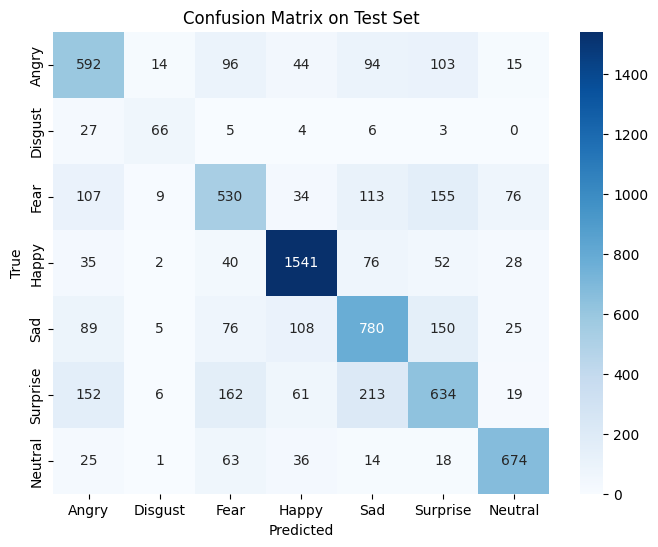

In [8]:
# Load test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load model
final_emot_model = models.resnet18(pretrained=True)
num_ftrs = final_emot_model.fc.in_features
final_emot_model.fc = nn.Linear(num_ftrs, 7)  # 7 emotion classes
final_emot_model = model_emot.to(device)
final_emot_model.load_state_dict(torch.load('best_emotion_model.pth'))
final_emot_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device).float()
        labels = labels.to(device).long()

        outputs = final_emot_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=[
    'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'
]))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
    'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'
], yticklabels=[
    'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'
])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()


## Training on the full data set

In [9]:
full_torch_dataset = FERDataset(full_dataset, transform=transform)

final_loader = DataLoader(full_torch_dataset, batch_size=64, shuffle=True)

final_emot_model = models.resnet18(pretrained=True)
num_ftrs = final_emot_model.fc.in_features
final_emot_model.fc = nn.Linear(num_ftrs, 7)  # 7 emotion classes
model_emot = final_emot_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_emot_model.parameters(), lr=1e-4)

print("\n=== Final Training on All Data ===")
for epoch in range(15):
    final_emot_model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in final_loader:
        images, labels = images.to(device).float(), labels.to(device).long()

        optimizer.zero_grad()
        outputs = final_emot_model(images)
        loss = criterion(outputs, labels)

        l1_norm = sum(p.abs().sum() for p in final_emot_model.parameters())
        loss = loss + 1e-5 * l1_norm

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(full_dataset)
    epoch_acc = correct.float() / len(full_dataset)
    print(f"Epoch {epoch + 1}/15 - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

torch.save(final_emot_model.state_dict(), 'final_best_emot_model.pth')
print("\nFinal model saved as 'final_best_emot_model.pth'")



=== Final Training on All Data ===
Epoch 1/15 - Loss: 2.7595, Acc: 0.5806
Epoch 2/15 - Loss: 2.3545, Acc: 0.7137
Epoch 3/15 - Loss: 2.0313, Acc: 0.8159
Epoch 4/15 - Loss: 1.7394, Acc: 0.9074
Epoch 5/15 - Loss: 1.5651, Acc: 0.9537
Epoch 6/15 - Loss: 1.4756, Acc: 0.9672
Epoch 7/15 - Loss: 1.4184, Acc: 0.9707
Epoch 8/15 - Loss: 1.3855, Acc: 0.9683
Epoch 9/15 - Loss: 1.3583, Acc: 0.9666
Epoch 10/15 - Loss: 1.3087, Acc: 0.9753
Epoch 11/15 - Loss: 1.2722, Acc: 0.9768
Epoch 12/15 - Loss: 1.2508, Acc: 0.9765
Epoch 13/15 - Loss: 1.2358, Acc: 0.9748
Epoch 14/15 - Loss: 1.2068, Acc: 0.9772
Epoch 15/15 - Loss: 1.1861, Acc: 0.9783

Final model saved as 'final_best_model.pth'


## Using Pytorch for facial confidence estimation

In [10]:
# Step 1: Dataset wrapper
class FaceConfidenceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']

        # Ensure RGB
        if isinstance(img, str):
            img = Image.open(img).convert('RGB')
        else:
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

# Step 2: Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale RGB
    transforms.Resize((224, 224)),                # Resize to match ResNet input
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406],   # Normalize (ImageNet mean)
                         [0.229, 0.224, 0.225])   # Normalize (ImageNet std)
])

# Step 2.1: Get data set
ds = load_dataset("march18/FacialConfidence")
df_train = pd.DataFrame.from_dict(ds['train'])
df_test = pd.DataFrame.from_dict(ds['test'])

# Step 3: Dataloaders
train_dataset = FaceConfidenceDataset(df_train, transform)
test_dataset = FaceConfidenceDataset(df_test, transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Training resnet18 model for labeling confident face

In [12]:
# Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

epochs = 15
best_val_acc = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    # Step the scheduler
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")

    # Save best model (optional)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_conf_model.pth')
        print(f"✅ Best model saved at epoch {epoch + 1} with val acc: {val_acc:.4f}")


Epoch 1/15 Train Loss: 0.4306 Train Acc: 0.7955 Val Loss: 0.4022 Val Acc: 0.8215
✅ Best model saved at epoch 1 with val acc: 0.8215
Epoch 2/15 Train Loss: 0.2914 Train Acc: 0.8742 Val Loss: 0.3875 Val Acc: 0.8300
✅ Best model saved at epoch 2 with val acc: 0.8300
Epoch 3/15 Train Loss: 0.1764 Train Acc: 0.9289 Val Loss: 0.4894 Val Acc: 0.8307
✅ Best model saved at epoch 3 with val acc: 0.8307
Epoch 4/15 Train Loss: 0.0902 Train Acc: 0.9665 Val Loss: 0.5520 Val Acc: 0.8335
✅ Best model saved at epoch 4 with val acc: 0.8335
Epoch 5/15 Train Loss: 0.0659 Train Acc: 0.9763 Val Loss: 0.6061 Val Acc: 0.8396
✅ Best model saved at epoch 5 with val acc: 0.8396
Epoch 6/15 Train Loss: 0.0237 Train Acc: 0.9928 Val Loss: 0.6312 Val Acc: 0.8530
✅ Best model saved at epoch 6 with val acc: 0.8530
Epoch 7/15 Train Loss: 0.0062 Train Acc: 0.9989 Val Loss: 0.6457 Val Acc: 0.8553
✅ Best model saved at epoch 7 with val acc: 0.8553
Epoch 8/15 Train Loss: 0.0038 Train Acc: 0.9993 Val Loss: 0.6916 Val Acc: 0.

## Loading the model for detecting facial confidence and emotion

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Recreate the model architecture
model_conf = models.resnet18(pretrained=False)
num_ftrs = model_conf.fc.in_features
model_conf.fc = nn.Linear(num_ftrs, 2)  # 2 classes: confident (0), non-confident (1)

# Load saved weights
model_conf.load_state_dict(torch.load('best_conf_model.pth', map_location=device))
model_conf.to(device)
model_conf.eval()

# Recreate the model architecture
model_emot = models.resnet18(pretrained=False)
num_ftrs = model_emot.fc.in_features
model_emot.fc = torch.nn.Linear(num_ftrs, 7)  # 7 emotion classes

# Load saved weights
model_emot.load_state_dict(torch.load('best_emotion_model.pth', map_location=device))
model_emot.to(device)
model_emot.eval()

# Define transforms
transform_conf = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale RGB
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_emot = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale RGB
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # adjust if needed
])

## Plotting confusion matrix and classification report for the best model predicting confidence 

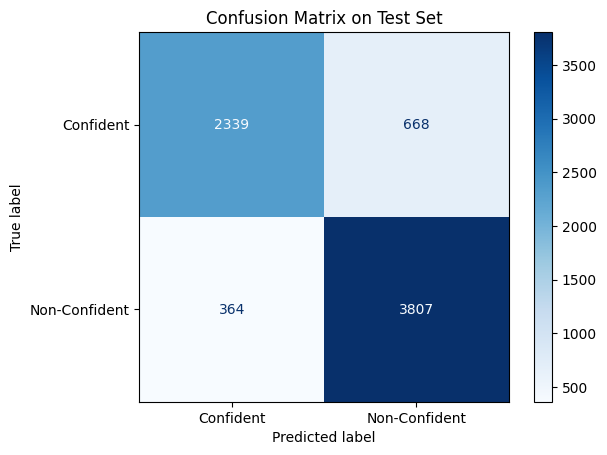

In [11]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_conf(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Confident', 'Non-Confident'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.show()

In [23]:
report = classification_report(all_labels, all_preds, target_names=['Confident', 'Non-Confident'])

print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

    Confident       0.87      0.78      0.82      3007
Non-Confident       0.85      0.91      0.88      4171

     accuracy                           0.86      7178
    macro avg       0.86      0.85      0.85      7178
 weighted avg       0.86      0.86      0.85      7178



In [7]:
# Setup Mediapipe

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.6)

# Open webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to RGB for Mediapipe
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detection.process(rgb_frame)

    if results.detections:
        for detection in results.detections:
            bbox = detection.location_data.relative_bounding_box
            h, w, _ = frame.shape
            x1 = int(bbox.xmin * w)
            y1 = int(bbox.ymin * h)
            x2 = x1 + int(bbox.width * w)
            y2 = y1 + int(bbox.height * h)

            # Ensure box is within frame
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            face_img = frame[y1:y2, x1:x2]

            try:
                # Analyze emotion with DeepFace
                result = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False)
                dominant_emotion = result[0]['dominant_emotion']

                # Predict confidence with your model
                pil_face = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
                input_tensor = transform_conf(pil_face).unsqueeze(0).to(device)
                output = model_conf(input_tensor)
                _, pred = torch.max(output, 1)
                confidence_label = 'Confident' if pred.item() == 0 else 'Non-Confident'

                # Combine labels
                combined_label = f"{dominant_emotion}, {confidence_label}"

                # Draw bounding box and labels
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, combined_label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

            except Exception as e:
                print(f"Error: {e}")

    cv2.imshow('Live Emotion + Confidence Analyzer', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


I0000 00:00:1748483436.784706 4816198 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1748483436.787294 4817969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


KeyboardInterrupt: 

In [5]:
# Setup Mediapipe
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.6)

# Video input
video_path = '/Users/renan/code/reneiji/non_verbal_comm/notebooks/RA_note/You are contagious _ Vanessa Van Edwards _ TEDxLondon.mp4'
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

# Counters
total_confident = 0
total_non_confident = 0
emotion_counter = Counter()
total_face_frames = 0

frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % int(fps) == 0:  # process 1 frame per second
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(rgb_frame)

        if results.detections:
            for detection in results.detections:
                bbox = detection.location_data.relative_bounding_box
                h, w, _ = frame.shape
                x1 = int(bbox.xmin * w)
                y1 = int(bbox.ymin * h)
                x2 = x1 + int(bbox.width * w)
                y2 = y1 + int(bbox.height * h)

                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)

                face_img = frame[y1:y2, x1:x2]

                try:
                    # DeepFace emotion
                    result = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False)
                    dominant_emotion = result[0]['dominant_emotion']
                    emotion_counter[dominant_emotion] += 1

                    # Confidence prediction
                    pil_face = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
                    input_tensor = transform_conf(pil_face).unsqueeze(0).to(device)
                    output = model_conf(input_tensor)
                    _, pred = torch.max(output, 1)

                    if pred.item() == 0:
                        total_confident += 1
                    else:
                        total_non_confident += 1

                    total_face_frames += 1

                except Exception as e:
                    print(f"Error: {e}")

    frame_idx += 1

cap.release()

# Calculate scores
total_conf = total_confident + total_non_confident
confidence_pct = (total_confident / total_conf) * 100 if total_conf > 0 else 0

top_emotions = emotion_counter.most_common(3)
emotion_summary = {emotion: (count / sum(emotion_counter.values())) * 100 for emotion, count in top_emotions}

# Output results
print(f"\n--- Video Analysis Results ---")
print(f"Confidence Level (Confident % over all faces): {confidence_pct:.2f}%")
print("\nTop 3 Dominant Emotions:")
for emotion, pct in emotion_summary.items():
    print(f"{emotion}: {pct:.2f}%")


I0000 00:00:1748482105.871643 4779938 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1748482105.872974 4782023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



--- Video Analysis Results ---
Confidence Level (Confident % over all faces): 52.81%

Top 3 Dominant Emotions:
sad: 43.04%
happy: 25.78%
neutral: 17.26%


## Wrapping emotion and confidence analysis in a usable function

In [ ]:
def analyze_video(model_conf, emot_conf_thresh=0.6, model_emot=None,
                  use_deepface=False, video_path=None, device=None):
    import cv2
    import numpy as np
    import torch
    from collections import Counter
    from PIL import Image
    from deepface import DeepFace
    import mediapipe as mp
    import time

    is_live = video_path is None

    # Setup Mediapipe face detection
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.6)

    # Video capture: webcam (0) or file path
    def get_working_camera():
        for i in range(3):
            cap = cv2.VideoCapture(i)
            if cap.isOpened():
                print(f"Using camera {i} for live detection.")
                return cap
        cap.release()
        raise RuntimeError("No working camera found.")
    cap = get_working_camera() if is_live else cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0 or np.isnan(fps):
        fps = 30

    # Counters
    total_confident = 0
    total_non_confident = 0
    emotion_counter = Counter()
    no_face_count = 0

    # FER2013 label map (if using model_emot)
    label_map = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
                 4: 'sad', 5: 'surprise', 6: 'neutral'}

    frame_count = 0
    ANALYZE_EVERY_N_FRAMES = int(fps)  # ~1 sec intervals

    # Keep last known box + label
    last_combined_label = None
    last_bbox = None

    start_time = time.time()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        if frame_count % ANALYZE_EVERY_N_FRAMES == 0:
            # Perform detection + predictions
            results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if results.detections:
                detection = results.detections[0]  # take first face
                bbox = detection.location_data.relative_bounding_box
                h, w, _ = frame.shape
                x1 = int(bbox.xmin * w)
                y1 = int(bbox.ymin * h)
                x2 = x1 + int(bbox.width * w)
                y2 = y1 + int(bbox.height * h)

                face_img = frame[max(0, y1):min(h, y2), max(0, x1):min(w, x2)]
                pil_face_rgb = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))

                try:
                    # --- Emotion detection ---
                    if not use_deepface and model_emot is None:
                        raise ValueError("You must provide a model_emot when use_deepface is False.")
                    if use_deepface:
                        result = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False)
                        dominant_emotion = result[0]['dominant_emotion']
                    else:
                        input_tensor_emot = transform_emot(pil_face_rgb).unsqueeze(0).to(device).float()
                        output = model_emot(input_tensor_emot)
                        # Get probability of emotion labeling
                        probabilities = F.softmax(output, dim=1)
                        confidence, pred = torch.max(probabilities, 1)
                        if confidence < emot_conf_thresh:
                            pred = torch.tensor([6], device=output.device)
                        dominant_emotion = label_map[pred.item()]
                    emotion_counter[dominant_emotion] += 1

                    # --- Confidence detection ---
                    pil_face = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
                    input_tensor_conf = transform_conf(pil_face).unsqueeze(0).to(device).float()
                    output_conf = model_conf(input_tensor_conf)
                    _, pred_conf = torch.max(output_conf, 1)

                    if pred_conf.item() == 0:
                        total_confident += 1
                        confidence_label = "Confident"
                    else:
                        total_non_confident += 1
                        confidence_label = "Non-Confident"

                    last_combined_label = f"{dominant_emotion}, {confidence_label}"
                    last_bbox = (x1, y1, x2, y2)

                except Exception as e:
                    print(f"Error during analysis: {e}")

            else:
                no_face_count += 1

            frame_count = 0

        # Always draw the **last known box + label** (if any)
        if is_live and last_bbox and last_combined_label:
            x1, y1, x2, y2 = last_bbox
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, last_combined_label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        if is_live:
            cv2.imshow('Live Emotion + Confidence Analyzer', frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    if is_live:
        cv2.destroyAllWindows()

    elapsed_time = time.time() - start_time
    print(f"\n--- Video Analysis Results ---")
    print(f"Processed in {elapsed_time:.2f} seconds")

    total_conf = total_confident + total_non_confident
    confidence_pct = (total_confident / total_conf) * 100 if total_conf > 0 else 0

    top_emotions = emotion_counter.most_common(3)
    emotion_summary = {emotion: (count / sum(emotion_counter.values())) * 100
                       for emotion, count in top_emotions}

    print(f"Confidence Level (Confident % over all faces): {confidence_pct:.2f}%")
    print(f"No face detected on {no_face_count} frame groups")
    print("\nTop 3 Dominant Emotions:")
    for emotion, pct in emotion_summary.items():
        print(f"{emotion}: {pct:.2f}%")


In [4]:
analyze_video(model_conf, video_path=None, device=device)

I0000 00:00:1748684033.790381 6413026 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1748684033.792203 6414700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Using camera 0 for live detection.


KeyboardInterrupt: 

In [ ]:
label_map = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
             4: 'sad', 5: 'surprise', 6: 'neutral'}



def predict_top_emotions(image_path, model, transform, label_map, device=device, top_n=3):
    """
    Predicts the top N emotions from an image, with their confidence scores.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): The PyTorch emotion model.
        transform (torchvision.transforms.Compose): The preprocessing transform.
        label_map (dict): Mapping from class index to emotion label.
        device (str): 'cpu' or 'cuda'.
        top_n (int): Number of top predictions to return.

    Returns:
        List[tuple]: List of (emotion_label (str), confidence (float)), sorted by confidence.
    """
    # Load image as RGB
    pil_image = Image.open(image_path).convert("RGB")

    # Apply transform
    input_tensor = transform(pil_image).unsqueeze(0).to(device).float()

    # Make sure model is in eval mode
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)  # raw logits
        probabilities = F.softmax(output, dim=1).squeeze()  # shape: [num_classes]

        # Get top N predictions
        top_confidences, top_indices = torch.topk(probabilities, top_n)

        top_predictions = []
        for i in range(top_n):
            label = label_map[top_indices[i].item()]
            confidence = top_confidences[i].item()
            top_predictions.append((label, confidence))

    return top_predictions


In [9]:
image_path = "/Users/renan/Downloads/portrait-of-a-charming-girl-without-makeup-that-looks-right-and-smiling-photo.jpg"
top_results = predict_top_emotions(image_path, model_emot, transform_emot, label_map, device, top_n=3)

print("Top emotions:")
for label, confidence in top_results:
    print(f"- {label}: {confidence:.2f}")


Top emotions:
- surprise: 0.76
- angry: 0.23
- happy: 0.01
